<a href="https://colab.research.google.com/github/jesusGS01/BDGE/blob/main/hbase/sesion6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoSQL (HBase) (sesión 6)

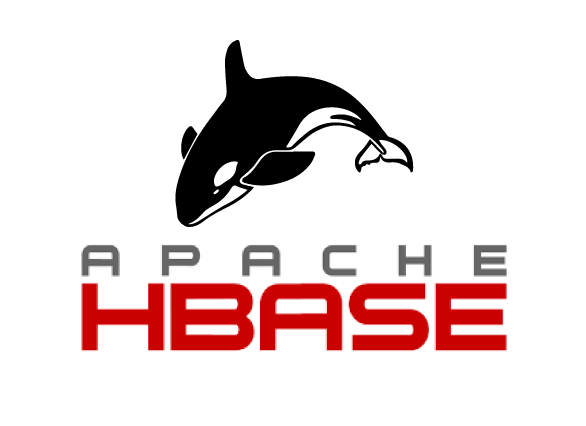



Esta hoja muestra cómo acceder a bases de datos HBase y también a conectar la salida con Jupyter.

Se puede utilizar el *shell* propio de HBase en la máquina virtual.

Con HBase vamos a simular un modo _semi-clúster_ con una sola máquina.


Instalamos la versión 8 de Java y la seleccionamos como opción por defecto:


In [59]:
%%capture
import os       #importing os to set environment variable
def install_java():
  !apt-get update -qq > /dev/null
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()
!update-java-alternatives -s java-1.8.0-openjdk-amd64

In [60]:
!pip install bs4 lxml

In [61]:
# Determinar qué versión 2.x es mayor de hbase
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re

version_re = re.compile(r'^(2\.[0-9]+(\.[0-9]+)?)')
req = Request("https://downloads.apache.org/hbase/")
html_page = urlopen(req)

soup = BeautifulSoup(html_page)

bigger2x = '2.0.0'  # Base version 2.x.x
for link in soup.findAll('a'):
  mresult = version_re.match(link.get_text())
  if mresult and mresult.group(0) > bigger2x:
    bigger2x = mresult.group(0)

In [62]:
%env HBASE_VERSION=$bigger2x

env: HBASE_VERSION=2.5.6


In [63]:
%%bash
wget -q https://downloads.apache.org/hbase/$HBASE_VERSION/hbase-$HBASE_VERSION-bin.tar.gz
tar -xzf hbase-$HBASE_VERSION-bin.tar.gz

In [64]:
%%bash
hbase-$HBASE_VERSION/bin/start-hbase.sh
hbase-$HBASE_VERSION/bin/hbase-daemon.sh restart thrift

master running as process 4461. Stop it first.
running thrift, logging to /content/hbase-2.5.6/bin/../logs/hbase--thrift-f0ea66bdf130.out
running thrift, logging to /content/hbase-2.5.6/bin/../logs/hbase--thrift-f0ea66bdf130.out
stopping thrift.
running thrift, logging to /content/hbase-2.5.6/bin/../logs/hbase--thrift-f0ea66bdf130.out


In [65]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `happybase` para python. La cargamos a continuación y hacemos la conexión.

In [66]:
!pip install happybase

In [67]:
import gzip
from urllib.request import Request,urlopen
import io
import os
import os.path as path

def download_csv(baseurl, filename):
    file = path.abspath(path.join(os.getcwd(),filename))
    request = Request(baseurl + '/' + filename+'.gz?raw=true')
    response = urlopen(request)
    buf = io.BytesIO(response.read())
    f = gzip.GzipFile(fileobj=buf)
    data = f.read()
    with open (filename, 'wb') as ff:
      ff.write(data)

baseurl = 'https://github.com/dsevilla/bdge-data/blob/master/es.stackoverflow/'
download_csv(baseurl, 'Posts.csv')
download_csv(baseurl, 'Users.csv')
download_csv(baseurl, 'Tags.csv')
download_csv(baseurl, 'Comments.csv')
download_csv(baseurl, 'Votes.csv')

In [68]:
import happybase
from contextlib import contextmanager

HBASEHOST = 'localhost'

class Connection():

    def __init__(self, host):
        self.host = host
        self._genpool()

    def _genpool(self):
        self.pool = happybase.ConnectionPool(size=5, host=self.host)

    @contextmanager
    def connection(self):
        for _ in range(5): # Probar 5 veces a regenerar el pool
            for _ in range(5): # Probar 5 veces a conectar
                with self.pool.connection() as connection:
                    try:
                        connection.tables()
                        yield connection
                        return
                    except Exception as e:
                        pass
            self._genpool()
        raise Exception("HBase Connection Error")

In [69]:
hbasecon = Connection(HBASEHOST)

In [70]:
with hbasecon.connection() as connection:
    print(connection.tables())

[b'comments', b'posts', b'poststags', b'tags', b'users', b'votes', b'wikipedia']


Para la carga inicial, vamos a crear todas las tablas con una única familia de columnas, `rawdata`, donde meteremos toda la información _raw_ comprimida. Después podremos hacer reorganizaciones de los datos para hacer el acceso más eficiente. Es una de las muchas ventajas de no tener un esquema.

In [71]:
# Create tables
tables = ['posts', 'votes', 'users', 'tags', 'comments']
for t in tables:
    try:
        with hbasecon.connection() as connection:
            connection.create_table(
                t,
                {
                    'rawdata': dict(max_versions=1,compression='GZ')
                })
    except Exception as e:
        print("Database already exists: {0}. {1}".format(t, e))
        pass
with hbasecon.connection() as connection:
    print(connection.tables())

Database already exists: posts. generator didn't stop after throw()
Database already exists: votes. generator didn't stop after throw()
Database already exists: users. generator didn't stop after throw()
Database already exists: tags. generator didn't stop after throw()
Database already exists: comments. generator didn't stop after throw()
[b'comments', b'posts', b'poststags', b'tags', b'users', b'votes', b'wikipedia']


El código de importación es siempre el mismo, ya que se coge la primera fila del CSV que contiene el nombre de las columnas y se utiliza para generar nombres de columnas dentro de la familia de columnas dada como parámetro. La función `csv_to_hbase()` acepta un fichero CSV a abrir, un nombre de tabla y una familia de columnas donde agregar las columnas del fichero CSV. En nuestro caso siempre va a ser `rawdata`.

In [72]:
import csv

def csv_to_hbase(file, tablename, column_family):
    with hbasecon.connection() as connection, open(file) as f:
        table = connection.table(tablename)

        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)
        columns = [column_family + ':' + c for c in columns]

        with table.batch(batch_size=500) as b:
            for row in reader:
                # La primera columna se usará como Row Key
                b.put(row[0], dict(zip(columns, row)))

In [73]:
for t in tables:
    print("Importando tabla {0}...".format(t))
    %time csv_to_hbase(t.capitalize() + '.csv', t, 'rawdata')

Importando tabla posts...
CPU times: user 9.04 s, sys: 288 ms, total: 9.33 s
Wall time: 32.1 s
Importando tabla votes...
CPU times: user 4.89 s, sys: 83.6 ms, total: 4.98 s
Wall time: 17.3 s
Importando tabla users...
CPU times: user 3.22 s, sys: 59.5 ms, total: 3.28 s
Wall time: 10.8 s
Importando tabla tags...
CPU times: user 40.8 ms, sys: 3.87 ms, total: 44.6 ms
Wall time: 169 ms
Importando tabla comments...
CPU times: user 3.43 s, sys: 83.3 ms, total: 3.51 s
Wall time: 10.5 s


### Consultas sencillas desde Python

A continuación veremos algunas consultas sencillas desde python usando el API de `happybase`.

In [74]:
def posts():
  with hbasecon.connection() as connection:
    return connection.table('posts')

Obtener el Post con `Id` 5. La orden más sencilla e inmediata de HBase es obtener una fila, opcionalmente limitando las columnas a mostrar:

In [75]:
posts().row(b'5',columns=[b'rawdata:Body'])

{b'rawdata:Body': b'<p>\xc2\xbfCu\xc3\xa1l es la forma m\xc3\xa1s eficiente de separar un string en <code>c++</code>? como el que se muestra en el c\xc3\xb3digo, el cual contiene espacios entre las palabras, este es el m\xc3\xa9todo que yo estoy usando actualmente.</p><br/><br/><pre><code>#include <iostream><br/>#include <sstream><br/><br/>int main(int argc, char** argv){<br/><br/>    std::string str("Texto para dividir");<br/>    std::istringstream isstream(str);<br/><br/>    while(!isstream.eof()){<br/><br/>        std::string tempStr;<br/><br/>        isstream >> tempStr;<br/><br/>        std::cout << tempStr << std::endl;<br/>    }<br/><br/>    return 0;<br/>}<br/></code></pre><br/>'}

El siguiente código permite mostrar de forma amigable las tablas extraídas de la base de datos en forma de diccionario:

In [76]:
# http://stackoverflow.com/a/30525061/62365
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        htmltext = ["<table width=100%>"]
        for key, value in self.items():
            htmltext.append("<tr>")
            htmltext.append("<td>{0}</td>".format(key.decode('utf-8')))
            htmltext.append("<td>{0}</td>".format(value.decode('utf-8')))
            htmltext.append("</tr>")
        htmltext.append("</table>")
        return ''.join(htmltext)

In [77]:
# Muestra cómo queda la fila del Id del Post 9997
DictTable(posts().row(b'5'))

comments:CreationDate_1477,2015-12-10T16:34:36.243
comments:Id_1477,1477
comments:PostId_1477,5
comments:Score_1477,2
comments:Text_1477,"Cuidado con usar espacios para separar palabras, hay varios idiomas (como chino) que no usan espacios. Incluso en idiomas con caracteres latinos hay palabras como parlez-vous francais? en el que no se usa el espacio como separador. ICU tiene una libreria genial para todos los casos. http://userguide.icu-project.org/boundaryanalysis"
comments:UserDisplayName_1477,
comments:UserId_1477,718
rawdata:AcceptedAnswerId,208
rawdata:AnswerCount,6
rawdata:Body,"¿Cuál es la forma más eficiente de separar un string en c++? como el que se muestra en el código, el cual contiene espacios entre las palabras, este es el método que yo estoy usando actualmente.#include #include int main(int argc, char** argv){ std::string str(""Texto para dividir""); std::istringstream isstream(str); while(!isstream.eof()){ std::string tempStr; isstream >> tempStr; std::cout << tempStr << std::endl; } return 0;}"
rawdata:ClosedDate,


In [78]:
DictTable(posts().row(b'5',columns=[b'rawdata:AnswerCount',b'rawdata:AcceptedAnswerId']))

rawdata:AcceptedAnswerId,208
rawdata:AnswerCount,6


Y también se puede recorrer como un diccionario normal (el `decode` se utiliza para convertir los valores binarios de la base de datos a una codificación UTF-8):

In [79]:
row = posts().row(b'5')
for key, value in row.items():
    print("Key = '%s', Value = '%s'" %(key,value.decode('utf-8')[:40]))

Key = 'b'comments:CreationDate_1477'', Value = '2015-12-10T16:34:36.243'
Key = 'b'comments:Id_1477'', Value = '1477'
Key = 'b'comments:PostId_1477'', Value = '5'
Key = 'b'comments:Score_1477'', Value = '2'
Key = 'b'comments:Text_1477'', Value = 'Cuidado con usar espacios para separar p'
Key = 'b'comments:UserDisplayName_1477'', Value = ''
Key = 'b'comments:UserId_1477'', Value = '718'
Key = 'b'rawdata:AcceptedAnswerId'', Value = '208'
Key = 'b'rawdata:AnswerCount'', Value = '6'
Key = 'b'rawdata:Body'', Value = '<p>¿Cuál es la forma más eficiente de se'
Key = 'b'rawdata:ClosedDate'', Value = ''
Key = 'b'rawdata:CommentCount'', Value = '1'
Key = 'b'rawdata:CommunityOwnedDate'', Value = ''
Key = 'b'rawdata:CreationDate'', Value = '2015-10-30T01:15:27.267'
Key = 'b'rawdata:FavoriteCount'', Value = ''
Key = 'b'rawdata:Id'', Value = '5'
Key = 'b'rawdata:LastActivityDate'', Value = '2017-03-04T04:16:19.167'
Key = 'b'rawdata:LastEditDate'', Value = '2016-09-27T17:46:24.900'
Key = 'b'rawdata:La

Finalmente, también se puede recorrer toda la tabla estableciendo filtros, que se estudiarán después. Se utiliza la función `scan`. Se puede iterar con los parámetros `key` y `data`. Por ejemplo, calcular el tamaño máximo de la longitud del texto de los posts:

**(OJO, es un ejemplo, no se debería hacer así)**

In [80]:
max_len = 0
for key, data in posts().scan(columns=[b'rawdata:Body']):
    cur_len = len(data[b'rawdata:Body'])
    if cur_len > max_len:
        max_len = cur_len

print("Máxima longitud: %s caracteres." % (max_len))

Máxima longitud: 38200 caracteres.


### Construcción de estructuras anidadas

Al igual que pasaba con MongoDB, las bases de datos NoSQL como en este caso HBase permiten almacenar estructuras de datos complejas. En nuestro caso vamos a agregar los comentarios de cada pregunta o respuesta (post) en columnas del mismo. Para ello, creamos una nueva familia de columnas `comments`.

HBase es bueno para añadir columnas sencillas, por ejemplo que contengan un valor. Sin embargo, si queremos añadir objetos complejos, tenemos que jugar con la codificación de la familia de columnas y columna.

Usaremos el shell porque `happybase` no permite alterar tablas ya creadas.

En el `shell` de HBase pondremos lo siguiente:

```
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
```

Cada comentario que añadimos contiene, al menos:

- un id único
- un texto
- un autor
- etc.

¿Cómo se consigue meterlo en una única familia de columnas?

Hay varias formas. La que usaremos aquí, añadiremos el **id** de cada comentario como parte del nombre de la columna. Por ejemplo, el comentario con Id 2000, generará las columnas:

- `Id_2000` (valor 2000)
- `UserId_2000`
- `PostId_2000`
- `Text_2000`

con sus correspondientes valores. Así, todos los datos relativos al comentario con Id original 2000, estarán almacenados en todas las columnas que terminen en "`_2000`". La base de datos permite implementar filtros que nos permiten buscar esto de forma muy sencilla. Los veremos después.

In [81]:
%%bash

cat <<EOF | hbase-$HBASE_VERSION/bin/hbase shell
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
exit
EOF

HBase Shell
Use "help" to get list of supported commands.
Use "exit" to quit this interactive shell.
For Reference, please visit: http://hbase.apache.org/2.0/book.html#shell
Version 2.5.6, r6bac842797dc26bedb7adc0759358e4c8fd5a992, Sat Oct 14 23:36:46 PDT 2023
Took 0.0030 seconds
hbase:001:0> disable 'posts'
Took 3.0401 seconds
hbase:002:0> alter 'posts', {NAME => 'comments', VERSIONS => 1}
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.2209 seconds
hbase:003:0> enable 'posts'
Took 0.6542 seconds
hbase:004:0> exit


In [82]:
with hbasecon.connection() as connection:
    comments = connection.table('comments')
    posts = connection.table('posts')

    with posts.batch(batch_size=500) as bp:
        # Hacer un scan de la tabla
        for key, data in comments.scan():
            comment = {'comments:' +
                       d.decode('utf-8').split(':')[1] + "_" +
                       key.decode('utf-8') :
                       data[d] for d in data.keys()}
            bp.put(data[b'rawdata:PostId'], comment)

In [83]:
download_csv('https://github.com/dsevilla/bdge-data/blob/master/wikipedia/','eswiki.xml')

Se crea la tabla para albergar la `wikipedia`. Igual que la vista en teoría, pero aquí se usa `wikipedia` en vez de `wiki` para que no colisionen la versión completa con la reducida.

De nuevo en el `shell` de HBase:

```
create 'wikipedia' , 'text', 'revision'
disable 'wikipedia' # Para evitar su uso temporal
alter 'wikipedia' , { NAME => 'text', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'revision', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'text', COMPRESSION => 'GZ', BLOOMFILTER => 'ROW'}
enable 'wikipedia'
```

In [84]:
%%bash

cat <<EOF | hbase-$HBASE_VERSION/bin/hbase shell
create 'wikipedia' , 'text', 'revision'
disable 'wikipedia' # Para evitar su uso temporal
alter 'wikipedia' , { NAME => 'text', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'revision', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'text', COMPRESSION => 'GZ', BLOOMFILTER => 'ROW'}
enable 'wikipedia'
exit
EOF

HBase Shell
Use "help" to get list of supported commands.
Use "exit" to quit this interactive shell.
For Reference, please visit: http://hbase.apache.org/2.0/book.html#shell
Version 2.5.6, r6bac842797dc26bedb7adc0759358e4c8fd5a992, Sat Oct 14 23:36:46 PDT 2023
Took 0.0061 seconds
hbase:001:0> create 'wikipedia' , 'text', 'revision'

ERROR: Table already exists: wikipedia!

For usage try 'help "create"'

Took 1.8290 seconds
hbase:002:0> disable 'wikipedia' # Para evitar su uso temporal
Took 0.5553 seconds
hbase:003:0> alter 'wikipedia' , { NAME => 'text', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.2535 seconds
hbase:004:0> alter 'wikipedia' , { NAME => 'revision', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.0612 seconds
hbase:005:0> alter 'wikipedia' , { NAME => 'text', COMPRESSION => 'GZ', BLOO

Este código, visto en teoría, recorre el árbol XML construyendo documentos y llamando a la función `callback` con cada uno. Los documentos son diccionarios con las claves encontradas dentro de los tags `<page>...</page>`.

In [85]:
import xml.sax
import re

class WikiHandler(xml.sax.handler.ContentHandler):

    def __init__(self):
        self._charBuffer = ''
        self.document = {}

    def _getCharacterData(self):
        data = self._charBuffer
        self._charBuffer = ''
        return data

    def parse(self, f, callback):
        self.callback = callback
        xml.sax.parse(f, self)

    def characters(self, data):
        self._charBuffer = self._charBuffer + data

    def startElement(self, name, attrs):
        if name == 'page':
        # print 'Start of page'
            self.document = {}
        if re.match(r'title|timestamp|username|comment|text', name):
            self._charBuffer = ''

    def endElement(self, name):
        if re.match(r'title|timestamp|username|comment|text', name):
            self.document[name] = self._getCharacterData()
            # print(name, ': ', self.document[name][:20])
        if 'revision' == name:
            self.callback(self.document)

El codigo a continuación, cada vez que el código anterior llama a la función `processdoc()` se añade un documento a la base de datos.

In [86]:
import time

class FillWikiTable():
    """Llena la tabla Wiki"""
    def __init__(self,connection):
        # Conectar a la base de datos a través de Thrift
        self.table = connection.table('wikipedia')

    def run(_s):
        def processdoc(d):
            print("Callback called with {0}".format(d['title']))
            tuple_time = time.strptime(d['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
            timestamp = int(time.mktime(tuple_time))
            _s.table.put(d['title'],
                         {'text:': d.get('text',''),
                          'revision:author': d.get('username',''),
                          'revision:comment': d.get('comment','')},
                         timestamp=timestamp)

        with open('eswiki.xml','r') as f:
            start = time.time()
            WikiHandler().parse(f, processdoc)
            end = time.time()
            print ("End adding documents. Time: %.5f" % (end - start))

In [87]:
with hbasecon.connection() as connection:
    FillWikiTable(connection).run()

Callback called with Wikipedia:Artículos solicitados
Callback called with Andorra
Callback called with Argentina
Callback called with Geografía de Andorra
Callback called with Demografía de Andorra
Callback called with Comunicaciones de Andorra
Callback called with Artes visuales
Callback called with Agricultura
Callback called with Astronomía galáctica
Callback called with ASCII
Callback called with Arquitectura
Callback called with Anoeta
Callback called with Ana María Matute
Callback called with Agujero negro
Callback called with Anarquía
Callback called with América del Norte
Callback called with América del Sur
Callback called with Asia
Callback called with Año
Callback called with Asaph Hall
Callback called with Afganistán
Callback called with Arqueología
Callback called with Wikipedia:Anuncios
Callback called with Commodore Amiga
Callback called with Commodore Amiga 500
Callback called with Francesc Aguilar Villalonga
Callback called with Aquifoliaceae
Callback called with Sapin

El código a continuación permite ver las diferentes versiones de una revisión. Como la versión reducida es muy pequeña no da lugar a que haya ninguna revisión, pero con este código se vería. Hace uso del _shell_ de HBase:

```    
get 'wikipedia', 'Commodore Amiga', {COLUMN => 'revision',VERSIONS=>10}
```

In [88]:
with hbasecon.connection() as connection:
    wikipedia = connection.table('wikipedia')
    for key,data in wikipedia.scan(columns=['revision'], row_start='A', row_stop='B', limit=10):
        print(key,'->',data)

b'A fala' -> {b'revision:author': b'KLBot2', b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'AGA' -> {b'revision:author': b'Savh', b'revision:comment': b'Savh movi\xc3\xb3 la p\xc3\xa1gina [[AGA (desambiguaci\xc3\xb3n)]] a [[AGA]]: Solicitado'}
b'ALGOL' -> {b'revision:author': b'G\xc3\xbcnniX', b'revision:comment': b'/* Enlaces externos y bibliograf\xc3\xada */'}
b'ASCII' -> {b'revision:author': b'', b'revision:comment': b''}
b'Abreviatura' -> {b'revision:author': b'', b'revision:comment': b'/* Diccionarios de abreviaturas */'}
b'Acacia' -> {b'revision:author': b'Jkbw', b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/212.55.25.241|212.55.25.241]] ([[User talk:212.55.25.241|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Jkbw'}
b'Acamptoclados' -> {b'revision:author': b'KLBot2', b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'Acarreo' -> {b'revision:author': b'Farisori', b'revision:comment': b'Revertidos lo

La siguiente consulta no poduce resultados. ¿Por qué?

In [89]:
with hbasecon.connection() as connection:
    wikipedia = connection.table('wikipedia')
    for key,data in wikipedia.scan(columns=['revision'], row_start='A', row_stop='B',
                                   filter="PrefixFilter('AS')", # Hay que poner A o AS , en vez de B
                                   limit=10):
        print (key,'->',data)

b'ASCII' -> {b'revision:author': b'', b'revision:comment': b''}


## En los siguientes ejercicios, usando `happybase`, utiliza o bien `scan` o bien `row` donde sea conveniente:

## EJERCICIO: Mostrar la familia de columnas `revision` para la entrada `ASCII` de la tabla `wikipedia`.

In [90]:
with hbasecon.connection() as connection:
    wikipedia = connection.table('wikipedia')
    row_ascii = wikipedia.row('ASCII',columns=['revision'])
    print(row_ascii)

{b'revision:author': b'', b'revision:comment': b''}


## EJERCICIO: Mostrar las 20 primeras filas de la tabla `wikipedia` cuyas columnas empiecen por 'com'.

In [91]:
with hbasecon.connection() as connection:
    wikipedia = connection.table('wikipedia')
    for key,data in wikipedia.scan(filter="ColumnPrefixFilter('com')",limit=20):
        print (key,'->',data)

b'A fala' -> {b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'AGA' -> {b'revision:comment': b'Savh movi\xc3\xb3 la p\xc3\xa1gina [[AGA (desambiguaci\xc3\xb3n)]] a [[AGA]]: Solicitado'}
b'ALGOL' -> {b'revision:comment': b'/* Enlaces externos y bibliograf\xc3\xada */'}
b'ASCII' -> {b'revision:comment': b''}
b'Abreviatura' -> {b'revision:comment': b'/* Diccionarios de abreviaturas */'}
b'Acacia' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/212.55.25.241|212.55.25.241]] ([[User talk:212.55.25.241|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Jkbw'}
b'Acamptoclados' -> {b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'Acarreo' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/~Expresses life|~Expresses life]] ([[User talk:~Expresses life|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Farisori'}
b'Acento l\xc3\xa9xico' -> {b'revision:comment': b'Peque\xc3\xb1as correcciones [[WP

## EJERCICIO: Mostrar las 20 primeras filas de la tabla `wikipedia` cuyas columnas empiecen por 'com' y la clave de fila empieza por 'B'.

In [92]:
with hbasecon.connection() as connection:
    wikipedia = connection.table('wikipedia')
    for key,data in wikipedia.scan(filter="ColumnPrefixFilter('com')",
                                   row_start='B',
                                   row_stop='C',
                                   limit=20):
        print (key,'->',data)

b'BASIC' -> {b'revision:comment': b'Correcciones ortogr\xc3\xa1ficas'}
b'BIOS' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/79.153.162.34|79.153.162.34]] ([[User talk:79.153.162.34|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Mansoncc'}
b'Bacteria' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/181.57.143.98|181.57.143.98]] ([[User talk:181.57.143.98|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Osado'}
b'Balanophoraceae' -> {b'revision:comment': b''}
b'Baloncesto' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/64.32.117.118|64.32.117.118]] ([[User talk:64.32.117.118|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Wiki LIC'}
b'Balsaminaceae' -> {b'revision:comment': b'Bot:Reparando enlaces'}
b'Bambuseae' -> {b'revision:comment': b''}
b'Bandera' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/Mariiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii|Mar

## EJERCICIO: Mostrar sólo la columna `revision:author` de las filas de la tabla `wikipedia` cuya clave empiece por `a` y termine por `a` (obviando mayúsculas y minúsculas).

In [93]:
with hbasecon.connection() as connection:
    wikipedia = connection.table('wikipedia')
    for key,data in wikipedia.scan(columns=['revision:author'], filter="RowFilter(=,'regexstring:^[Aa].*[Aa]$')"):
        print (key,'->',data)

b'A fala' -> {b'revision:author': b'KLBot2'}
b'AGA' -> {b'revision:author': b'Savh'}
b'Abreviatura' -> {b'revision:author': b''}
b'Acacia' -> {b'revision:author': b'Jkbw'}
b'Achlaena' -> {b'revision:author': b'KLBot2'}
b'Achneria' -> {b'revision:author': b'MILEPRI'}
b'Actual rey de Francia' -> {b'revision:author': b'CEM-bot'}
b'Ada' -> {b'revision:author': b'Solbaken'}
b'Adventista' -> {b'revision:author': b'Benjavalero'}
b'Afrodita' -> {b'revision:author': b'Foundling'}
b'Agricultura' -> {b'revision:author': b'Foundling'}
b'Agricultura ecol\xc3\xb3gica' -> {b'revision:author': b'Lin linao'}
b'Aira' -> {b'revision:author': b'BenjaBot'}
b'Airopsis tenella' -> {b'revision:author': b'BenjaBot'}
b'Ala' -> {b'revision:author': b'Shooke'}
b'Albania' -> {b'revision:author': b''}
b'Alberta' -> {b'revision:author': b'Alexandra Desir\xc3\xa9e Reyes'}
b'Aldea' -> {b'revision:author': b'4lextintor'}
b'Alegor\xc3\xada' -> {b'revision:author': b'Arjuno3'}
b'Alemania' -> {b'revision:author': b'Arjuno

## EJERCICIO: Mostrar las filas de la tabla `users` (sólo la columna `rawdata:Location`) de usuarios de España (se supondrá que su localización (columna `rawdata:Location`) contiene `España` o `ES`, obviando mayúsculas y minúsculas).

In [101]:
with hbasecon.connection() as connection:
    wikipedia = connection.table('users')
    for key,data in wikipedia.scan(columns =['rawdata:Location'],filter="SingleColumnValueFilter('rawdata','Location',=,'regexstring:\\b(españa|España|ES|es)\\b')"):
        print (key,'->',data)

b'10136' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'10335' -> {b'rawdata:Location': b'Matar\xc3\xb3, Espa\xc3\xb1a'}
b'10429' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'10497' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'10576' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'10692' -> {b'rawdata:Location': b'Sevilla, Espa\xc3\xb1a'}
b'10796' -> {b'rawdata:Location': b'Zaragoza, Espa\xc3\xb1a'}
b'10848' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'10862' -> {b'rawdata:Location': b'Santiago de Compostela, Espa\xc3\xb1a'}
b'10895' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'10915' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'11045' -> {b'rawdata:Location': b'Archena, Murcia, Espa\xc3\xb1a'}
b'11114' -> {b'rawdata:Location': b'Las Rozas, Espa\xc3\xb1a'}
b'11125' -> {b'rawdata:Location': b'Palencia, Espa\xc3\xb1a'}
b'11132' -> {b'rawdata:Location': b'Lleida, Catalu\xc3\xb1a, Espa\xc3\xb1a'}
b'11160' -> {b'rawdata:Location': 

## EJERCICIO: Crear una nueva tabla `poststags` que, de forma eficiente, para cada _tag_, liste los `Id` de los posts que utilizan ese _tag_.

*Nota: El código de ejemplo para separar todas las etiquetas del campo Tags de un post está en la sesión 1.*

Creamos la nueva tabla

In [95]:
%%bash
cat <<EOF | hbase-$HBASE_VERSION/bin/hbase shell
create 'poststags' , 'tag'
disable 'poststags' # Para evitar su uso temporal
alter 'poststags' , { NAME => 'tag', VERSIONS => 1, BLOOMFILTER => 'ROW'}
enable 'poststags'
exit
EOF

HBase Shell
Use "help" to get list of supported commands.
Use "exit" to quit this interactive shell.
For Reference, please visit: http://hbase.apache.org/2.0/book.html#shell
Version 2.5.6, r6bac842797dc26bedb7adc0759358e4c8fd5a992, Sat Oct 14 23:36:46 PDT 2023
Took 0.0036 seconds
hbase:001:0> create 'poststags' , 'tag'

ERROR: Table already exists: poststags!

For usage try 'help "create"'

Took 1.8741 seconds
hbase:002:0> disable 'poststags' # Para evitar su uso temporal
Took 0.6938 seconds
hbase:003:0> alter 'poststags' , { NAME => 'tag', VERSIONS => 1, BLOOMFILTER => 'ROW'}
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.2408 seconds
hbase:004:0> enable 'poststags'
Took 0.6396 seconds
hbase:005:0> exit


Rellenamos la nueva tabla

In [112]:
import re

with hbasecon.connection() as connection:
    posts = connection.table('posts')
    #poststags = connection.table('poststags')
    # Hacer un scan de la tabla
    for key, data in posts.scan(limit=30):
        dataTags = data[b'rawdata:Tags'].decode('utf-8')
        tags = re.findall('<(.*?)>', dataTags)
        if len(tags) > 0:
          for tag in tags:
            for key,data in posts.scan(columns =['rawdata:Tags'],filter="SingleColumnValueFilter('rawdata','Location',=,'substring:"+tag+"')"):
              print (key,'->',data)

        # tagPosts = {'comments:' +
        #            d.decode('utf-8').split(':')[1] + "_" +
        #            key.decode('utf-8') :
        #            data[d] for d in data.keys()}
        # bp.put(data[b'rawdata:PostId'], comment)

Se han truncado las últimas 5000 líneas del flujo de salida.
b'27568' -> {b'rawdata:Tags': b'<apache><cordova><phonegap>'}
b'2757' -> {b'rawdata:Tags': b''}
b'27570' -> {b'rawdata:Tags': b''}
b'27571' -> {b'rawdata:Tags': b''}
b'27572' -> {b'rawdata:Tags': b''}
b'27575' -> {b'rawdata:Tags': b''}
b'27576' -> {b'rawdata:Tags': b''}
b'27577' -> {b'rawdata:Tags': b''}
b'27578' -> {b'rawdata:Tags': b''}
b'27579' -> {b'rawdata:Tags': b''}
b'2758' -> {b'rawdata:Tags': b''}
b'27580' -> {b'rawdata:Tags': b''}
b'27581' -> {b'rawdata:Tags': b''}
b'27582' -> {b'rawdata:Tags': b''}
b'27583' -> {b'rawdata:Tags': b''}
b'27584' -> {b'rawdata:Tags': b'<c#><pdf>'}
b'27585' -> {b'rawdata:Tags': b''}
b'27586' -> {b'rawdata:Tags': b''}
b'27588' -> {b'rawdata:Tags': b'<java><jsf><primefaces><atmosphere>'}
b'27589' -> {b'rawdata:Tags': b''}
b'2759' -> {b'rawdata:Tags': b'<sql><visual-studio-2013>'}
b'27590' -> {b'rawdata:Tags': b''}
b'27591' -> {b'rawdata:Tags': b''}
b'27592' -> {b'rawdata:Tags': b'<c++>'}
b

Exception ignored in: <generator object Table.scan at 0x77fbcd1ce880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/happybase/table.py", line 434, in scan
    self.connection.client.scannerClose(scan_id)
  File "/usr/local/lib/python3.10/dist-packages/thriftpy2/thrift.py", line 219, in _req
    return self._recv(_api)
  File "/usr/local/lib/python3.10/dist-packages/thriftpy2/thrift.py", line 251, in _recv
    raise v
Hbase_thrift.IllegalArgument: IllegalArgument(message=b'scanner ID is invalid')


KeyboardInterrupt: ignored

## EJERCICIO: Crear una nueva tabla `userstags` que, de forma eficiente, para cada _tag_, liste los `Id` de los usuarios que han escrito posts de ese _tag_.

*Nota: El código de ejemplo para separar todas las etiquetas del campo Tags de un post está en la sesión 1.*

## EJERCICIO: Construya una tabla (de la forma más eficiente) que sirva para, dados un ID de usuario que pregunta y un ID de otro usuario que responde, se pueda decir (en orden constante) si forman una pareja al estilo de la RQ4. Con esa tabla, responder a la RQ4.